In [1]:
import pydicom
import matplotlib.pyplot as plt
import sigpy.plot as pl
#%matplotlib notebook
import subtle.utils.io as suio
from glob import glob
import numpy as np
import nibabel as nib
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import os
import numpy as np
from PIL import Image
from subtle.utils.experiment import get_experiment_data
from tqdm import tqdm_notebook as tqdm
from subtle.subtle_preprocess import dcm_to_sitk
import shutil
import SimpleITK as sitk

plt.set_cmap('gray')
plt.rcParams['figure.figsize'] = (12, 10)

from skimage.morphology import binary_erosion, cube
from subtle.utils.io import load_h5_file

/home/srivathsa/projects/SubtleGad/train/subtle/utils/hyperparameter.py:8: UserWarning: Module test_tube not found - hyperparameter related functions cannot be used
  warnings.warn('Module test_tube not found - hyperparameter related functions cannot be used')


<Figure size 432x288 with 0 Axes>

In [ ]:
data_t2 = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data/Patient_0389_T2.npy')
print(data_t2.shape)

In [ ]:
plt.imshow(data_t2[0, 156])

In [ ]:
dcm_path = '/home/srivathsa/projects/studies/gad/bracco/dcms/1755456/5_ax_3d_fspgr_mdc'
for fpath in glob('{}/*'.format(dcm_path)):
    fname = fpath.split('/')[-1]
    dcm_num = fname.split('.')[1].replace('\'', '')
    new_fname = 'IM_{:04d}.dcm'.format(int(dcm_num))
    new_fpath = '{}/{}'.format(dcm_path, new_fname)
    os.rename(fpath, new_fpath)

In [ ]:
vol = np.load('/home/srivathsa/projects/studies/gad/stanford/preprocess/data_smr/DNE/Patient_0171.npy')

In [ ]:
plt.imshow(np.hstack([vol[0, 160, 0], vol[0, 160, 1]]))

In [2]:
def get_dicom_vol(dirpath_dicom):
    dcm_files = sorted([f for f in glob('{}/*.dcm'.format(dirpath_dicom))])
    dcm = pydicom.dcmread(dcm_files[0])
    print('Series Description', dcm.SeriesDescription)
    return np.array([pydicom.dcmread(f).pixel_array for f in dcm_files])

Series Description AX T2
(31, 512, 512)


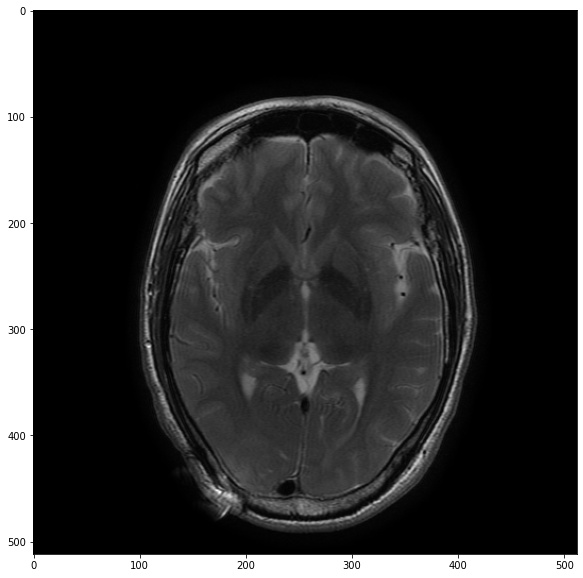

In [4]:
dcm_path = '/mnt/datasets/ben/backup/raid/SubtleGAD_Stanford/lowcon/lowcon_0012/015'
dcm_vol = get_dicom_vol(dcm_path)
print(dcm_vol.shape)
plt.imshow(dcm_vol[15])

In [ ]:
dcm_npy = np.load('/home/srivathsa/projects/studies/gad/bracco/preprocess/data_smr/1755456.npy')
plt.imshow(dcm_npy[0, 0, 0])
plt.colorbar()

In [ ]:
pp_data = np.load('/home/srivathsa/projects/studies/gad/bracco/preprocess/data/1002071.npy')[0]
plt.imshow(pp_data[0, 0])

In [ ]:
dcm1 = get_dicom_vol('/home/srivathsa/projects/studies/gad/bracco/dcms/1002071/7_st1w_3d_iso')
dcm2 = get_dicom_vol('/home/srivathsa/projects/studies/gad/bracco/dcms/1002071/9_st1w_3d_iso')

plt.imshow(np.hstack([dcm2[1], dcm1[1]]))

## Convert JPEG compression (decompress)

In [ ]:
base_path = '/home/srivathsa/projects/studies/gad/bracco/dcms/original'
dest_path = '/home/srivathsa/projects/studies/gad/bracco/dcms'
cases = ['1002071', '1231970', '1755456']

for cnum in cases:
    case_dir = os.path.join(base_path, cnum)
    ser_dirs = [s for s in glob('{}/*'.format(case_dir)) if os.path.isdir(s)]
    
    for ser_dir in ser_dirs:
        ser_name = ser_dir.split('/')[-1]
        ser_num = int(ser_name.split('_')[0])
        dcm_vol = get_dicom_vol(ser_dir)
        outpath = os.path.join(dest_path, cnum, ser_name)
        
        suio.write_dicoms(ser_dir, dcm_vol, outpath, series_desc_pre='', desc=ser_name, series_desc_post='', 
                          series_num=ser_num)

In [ ]:
output_single = '/raid/jiang/projects/SubtleGad/tiantan/data/4ea223_8ee157/'
#output_single = '/home/jiang/projects/SubtleGad/tiantan/data/4ea223_75d45d'
output_double = '/home/srivathsa/projects/studies/gad/tiantan/data/3aa100_aa734a'

In [ ]:
cases = ['33', '36', '41', '43', '46', '50', '53', '56', '58', '63', '68']
idxes = ['88', '98', '108', '136', '87', '146', '80', '75', '104', '129', '78']
for i, case in enumerate(cases):
    idx = int(idxes[i])
    vol1 = get_dicom_vol(f'{output_single}/NO{case}/NO{case}_SubtleGad/')
    vol2 = get_dicom_vol(f'{output_double}/NO{case}/NO{case}_SubtleGad/')
    vol = load_h5_file(f"/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO{case}.h5")
    slice_low = vol[idx, 1]*70
    slice_full = vol[idx, 2]*70
    slice1 = vol1[idx]
    slice2 = vol2[idx]
#     print(slice_low.min(), slice_low.max())
#     print(slice_full.min(), slice_full.max())
#     print(slice1.min(), slice1.max())
#     print(slice2.min(), slice2.max())
    slice_low = slice_low/slice_low.max()
    slice_full = slice_full/slice_full.max()
    slice1 = slice1/slice1.max()
    slice2 = slice2/slice2.max()
    
    img = np.concatenate((slice_low, slice1, slice2, slice_full), axis=1)
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.show()
    img = np.stack((img, img, img),axis=-1)
    img = np.uint8(255*img/img.max())
    im = Image.fromarray(img)
    os.makedirs(f"{output_single}/vis/", exist_ok=True)
    im.save(f"{output_single}/vis/NO{case}_{idx}.png")

In [ ]:
img.shape

In [ ]:
plt.imshow(slice_low, cmap='gray')

In [ ]:
y_pred = np.load('/home/srivathsa/projects/studies/gad/all/inference/y_pred.npy')
print(y_pred.shape)

In [ ]:
pl.ImagePlot(y_pred[..., 0])

In [ ]:
y_pred = np.load('/home/srivathsa/projects/studies/gad/all/inference/y_pred.npy')
print(y_pred.shape)
print(y_pred.dtype, y_pred.min(), y_pred.max())

In [ ]:
plt.imshow(y_pred[96, ..., 0])

In [ ]:
data = suio.load_file('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57.h5', params={'h5_key': 'all'})
uad = np.load('/home/srivathsa/projects/studies/gad/tiantan/preprocess/uad_masks/NO57.npy')

In [ ]:
dz = data[0, :, 0]
dl = data[0, :, 1]
diff = dl-dz
plt.imshow(diff[122])

In [ ]:
uad_mask = (uad >= (uad.max() * 0.1))
uad_mask = binary_erosion(uad_mask, selem=cube(7))
uad_mod = uad * uad_mask
dl_mod = dl + uad

mask = (data[1, :, 1] > 0.1)
dl_mod_mask = mask * dl_mod

In [ ]:
data_mod = data.copy()
data_mod[0, :, 1] = dl_mod
data_mod[1, :, 1] = dl_mod_mask

In [ ]:
suio.save_data_h5('/home/srivathsa/projects/studies/gad/tiantan/preprocess/data/NO57_mod.h5', 
                  data=data_mod[0], data_mask=data_mod[1])

In [ ]:
ixi_data = nib.load('/mnt/datasets/srivathsa/ixi/normal/IXI020-Guys-0700-T2.nii.gz').get_data()
sl = 60
disp = np.rot90(ixi_data[..., sl])
plt.imshow(disp)

In [ ]:
data = np.load('/home/srivathsa/projects/studies/gad/all/preprocess/data/Patient_0400.npy')

In [ ]:
data.shape

In [ ]:
meta = suio.load_h5_metadata('/home/srivathsa/projects/studies/gad/all/preprocess/data/Patient_0400_meta.h5')

In [ ]:
meta['zero_pad_size']

In [ ]:
base_path = '/home/srivathsa/projects/studies/gad/yichun/data'
cases = get_experiment_data('yichun', dirpath_exp='/home/srivathsa/projects/SubtleGad/train/configs/experiments')

for cnum in tqdm(cases, total=len(cases)):
    sers = [s for s in glob('{}/{}/*'.format(base_path, cnum))]
    for dirpath_ser in sers:
        ser_name = dirpath_ser.split('/')[-1]
        new_sname = ser_name.replace(' ', '_')
        snum = int(new_sname.split('_')[-1].replace('Series', ''))
        ser_fp = '_'.join(new_sname.split('_')[:-1])
        new_sname = '{}_Series_{}'.format(ser_fp, snum)
        shutil.move(dirpath_ser, '{}/{}/{}'.format(base_path, cnum, new_sname))

In [ ]:
dpath = '/home/srivathsa/projects/studies/gad/yichun/data/M034'
for fp in glob('{}/**/*.dcm'.format(dpath), recursive=True):
    try:
        dcm = pydicom.dcmread(fp)
    except Exception as exc:
        print(fp, exc)

In [ ]:
base_path = '/home/srivathsa/projects/studies/gad/stanford/preprocess/data'
cases = get_experiment_data('stanford_sri', dirpath_exp='/home/srivathsa/projects/SubtleGad/train/configs/experiments',
                           dataset='test')

for cnum in cases:
    if not os.path.isfile('{}/{}.npy'.format(base_path, cnum)):
        print(cnum)
